# GRHydro Tutorial

This tutorial is based on the [Einstein Toolkit tutorial](https://github.com/nds-org/jupyter-et/blob/master/tutorial-server/notebooks/CactusTutorial.ipynb) and it assumes that you have already installed the Einstein Toolkit.

It will require the installation of [kuibit](https://sbozzolo.github.io/kuibit/) in order to make some 2D plots and this is the first thing that will be done in the next cell.

In [1]:
!pip install kuibit

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit.simdir import SimDir
from kuibit.grid_data import UniformGrid

We now go into the Cactus directory (make sure to change the path accordingly to your system)

In [3]:
cd ~/EinsteinToolkit/ET_2022_05/Cactus

/home/bgiacoma/EinsteinToolkit/ET_2022_05/Cactus


In [4]:
!pwd

/home/bgiacoma/EinsteinToolkit/ET_2022_05/Cactus


We now create a parameter file to evolve a non-rotating stable neutron star with a polytropic equation of state

In [5]:
%%bash
cat >par/TOV_ET_Dublin.par <<"#EOF"
# Some basic stuff
ActiveThorns = "Time MoL"
ActiveThorns = "Coordbase CartGrid3d Boundary StaticConformal"
ActiveThorns = "SymBase ADMBase TmunuBase HydroBase InitBase ADMCoupling ADMMacros"
ActiveThorns = "IOUtil"
ActiveThorns = "Formaline"
ActiveThorns = "SpaceMask CoordGauge Constants LocalReduce aeilocalinterp LoopControl"
ActiveThorns = "Carpet CarpetLib CarpetReduce CarpetRegrid2 CarpetInterp"
ActiveThorns = "CarpetIOASCII CarpetIOScalar CarpetIOHDF5 CarpetIOBasic"

# Finalize
Cactus::terminate           = "time"
Cactus::cctk_final_time     = 400 # divide by ~203 to get ms

# Termination Trigger
ActiveThorns = "TerminationTrigger"
TerminationTrigger::max_walltime = 24          # hours
TerminationTrigger::on_remaining_walltime = 0  # minutes
TerminationTrigger::check_file_every = 512
TerminationTrigger::termination_file = "TerminationTrigger.txt"
TerminationTrigger::termination_from_file   = "yes"
TerminationTrigger::create_termination_file = "yes"

# grid parameters
Carpet::domain_from_coordbase = "yes"
CartGrid3D::type         = "coordbase"
CartGrid3D::domain       = "full"
CartGrid3D::avoid_origin = "no"
CoordBase::xmin =  0.0
CoordBase::ymin =  0.0
CoordBase::zmin =  0.0
CoordBase::xmax = 24.0
CoordBase::ymax = 24.0
CoordBase::zmax = 24.0
# Change these parameters to change resolution. The ?max settings above
# have to be multiples of these. 'dx' is the size of one cell in x-direction.
# Making this smaller means using higher resolution, because more points will
# be used to cover the same space.
CoordBase::dx   =   2.0
CoordBase::dy   =   2.0
CoordBase::dz   =   2.0

CarpetRegrid2::regrid_every =   0
CarpetRegrid2::num_centres  =   1
CarpetRegrid2::num_levels_1 =   2
CarpetRegrid2::radius_1[1]  = 12.0


CoordBase::boundary_size_x_lower        = 3
CoordBase::boundary_size_y_lower        = 3
CoordBase::boundary_size_z_lower        = 3
CoordBase::boundary_size_x_upper        = 3
CoordBase::boundary_size_y_upper        = 3
CoordBase::boundary_size_z_upper        = 3
CoordBase::boundary_shiftout_x_lower    = 1
CoordBase::boundary_shiftout_y_lower    = 1
CoordBase::boundary_shiftout_z_lower    = 1
CoordBase::boundary_shiftout_x_upper    = 0
CoordBase::boundary_shiftout_y_upper    = 0
CoordBase::boundary_shiftout_z_upper    = 0


ActiveThorns = "ReflectionSymmetry"

ReflectionSymmetry::reflection_x = "yes"
ReflectionSymmetry::reflection_y = "yes"
ReflectionSymmetry::reflection_z = "yes"
ReflectionSymmetry::avoid_origin_x = "no"
ReflectionSymmetry::avoid_origin_y = "no"
ReflectionSymmetry::avoid_origin_z = "no"

# storage and coupling
TmunuBase::stress_energy_storage = yes
TmunuBase::stress_energy_at_RHS  = yes
TmunuBase::timelevels            =  1
TmunuBase::prolongation_type     = none


HydroBase::timelevels            = 3

ADMMacros::spatial_order = 4

SpaceMask::use_mask      = "yes"

Carpet::enable_all_storage       = no
Carpet::use_buffer_zones         = "yes"

Carpet::poison_new_timelevels    = "yes"
Carpet::check_for_poison         = "no"

Carpet::init_3_timelevels        = no
Carpet::init_fill_timelevels     = "yes"

CarpetLib::poison_new_memory = "yes"
CarpetLib::poison_value      = 114

# system specific Carpet paramters
Carpet::max_refinement_levels    = 10
driver::ghost_size               = 3
Carpet::prolongation_order_space = 3
Carpet::prolongation_order_time  = 2

# Time integration
time::dtfac = 0.25

MoL::ODE_Method             = "rk4"
MoL::MoL_Intermediate_Steps = 4
MoL::MoL_Num_Scratch_Levels = 1

# check all physical variables for NaNs
#  This can save you computing time, so it's not a bad idea to do this
#  once in a whioe.
ActiveThorns = "NaNChecker"
NaNChecker::check_every = 16384
NaNChecker::action_if_found = "terminate" #"terminate", "just warn", "abort"
NaNChecker::check_vars = "ADMBase::metric ADMBase::lapse ADMBase::shift HydroBase::rho HydroBase::eps HydroBase::press HydroBase::vel"

# Hydro paramters

ActiveThorns = "EOS_Omni GRHydro"

HydroBase::evolution_method      = "GRHydro"

GRHydro::riemann_solver         = "Marquina"
GRHydro::GRHydro_eos_type       = "Polytype"
GRHydro::GRHydro_eos_table      = "2D_Polytrope"
GRHydro::recon_method           = "ppm"
GRHydro::GRHydro_stencil        = 3
GRHydro::bound                  = "none"
GRHydro::rho_abs_min            = 1.e-10
# Parameter controlling finite difference order of the Christoffel symbols in GRHydro
GRHydro::sources_spatial_order  = 4

# Curvature evolution parameters

ActiveThorns = "GenericFD NewRad"
ActiveThorns = "ML_BSSN ML_BSSN_Helper"
ADMBase::evolution_method        = "ML_BSSN"
ADMBase::lapse_evolution_method  = "ML_BSSN"
ADMBase::shift_evolution_method  = "ML_BSSN"
ADMBase::dtlapse_evolution_method= "ML_BSSN"
ADMBase::dtshift_evolution_method= "ML_BSSN"

ML_BSSN::timelevels = 3

ML_BSSN::harmonicN           = 1      # 1+log
ML_BSSN::harmonicF           = 2.0    # 1+log
ML_BSSN::evolveA             = 1
ML_BSSN::evolveB             = 1
ML_BSSN::ShiftGammaCoeff     = 0.75
ML_BSSN::BetaDriver          = 2.66
ML_BSSN::advectLapse         = 0.0
ML_BSSN::advectShift         = 0.0


ML_BSSN::initial_boundary_condition="extrapolate-gammas"
ML_BSSN::rhs_boundary_condition="NewRad"

# Some dissipation to get rid of high-frequency noise
ActiveThorns = "SphericalSurface Dissipation"
Dissipation::verbose   = "no"
Dissipation::epsdis   = 0.01
Dissipation::vars = "
        ML_BSSN::ML_log_confac
        ML_BSSN::ML_metric
        ML_BSSN::ML_curv
        ML_BSSN::ML_trace_curv
        ML_BSSN::ML_Gamma
        ML_BSSN::ML_lapse
        ML_BSSN::ML_shift
"


# init parameters
InitBase::initial_data_setup_method = "init_some_levels"

# Use TOV as initial data
ActiveThorns = "TOVSolver"

HydroBase::initial_hydro         = "tov"
ADMBase::initial_data            = "tov"
ADMBase::initial_lapse           = "tov"
ADMBase::initial_shift           = "tov"
ADMBase::initial_dtlapse         = "zero"
ADMBase::initial_dtshift         = "zero"

# Parameters for initial star
TOVSolver::TOV_Rho_Central[0] = 1.28e-3
TOVSolver::TOV_Gamma          = 2
TOVSolver::TOV_K              = 100

# Set equation of state for evolution
EOS_Omni::poly_gamma                   = 2
EOS_Omni::poly_k                       = 100
EOS_Omni::gl_gamma                     = 2
EOS_Omni::gl_k                         = 100


# I/O

# Use (create if necessary) an output directory named like the
# parameter file (minus the .par)
IO::out_dir             = ${parfile}

# Write one file overall per output (variable/group)
# In production runs, comment this or set to "proc" to get one file
# per MPI process
IO::out_mode            = "onefile"

# Some screen output
IOBasic::outInfo_every = 512
IOBasic::outInfo_vars  = "Carpet::physical_time_per_hour HydroBase::rho{reductions='maximum'}"

# Scalar output
IOScalar::outScalar_every    = 512
IOScalar::one_file_per_group = "yes"
IOScalar::outScalar_reductions = "norm1 norm2 norm_inf sum maximum minimum"
IOScalar::outScalar_vars     = "
 HydroBase::rho{reductions='maximum'}
 HydroBase::press{reductions='maximum'}
 HydroBase::eps{reductions='minimum maximum'}
 HydroBase::vel{reductions='minimum maximum'}
 HydroBase::w_lorentz{reductions='minimum maximum'}
 ADMBase::lapse{reductions='minimum maximum'}
 ADMBase::shift{reductions='minimum maximum'}
 ML_BSSN::ML_Ham{reductions='norm1 norm2 maximum minimum norm_inf'}
 ML_BSSN::ML_mom{reductions='norm1 norm2 maximum minimum norm_inf'}
 GRHydro::dens{reductions='minimum maximum sum'}
 Carpet::timing{reductions='average'}
"

# 1D ASCII output. Disable for production runs!
IOASCII::out1D_every        = -1
IOASCII::one_file_per_group = yes
IOASCII::output_symmetry_points = no
IOASCII::out1D_vars         = "
 HydroBase::rho
 HydroBase::press
 HydroBase::eps
 HydroBase::vel
 ADMBase::lapse
 ADMBase::metric
 ADMBase::curv
 ML_BSSN::ML_Ham
 ML_BSSN::ML_mom
"

# 2D HDF5 output
CarpetIOHDF5::output_buffer_points = "no"

CarpetIOHDF5::out2D_every = 2048
CarpetIOHDF5::out2D_vars = "
 HydroBase::rho
 HydroBase::eps
 HydroBase::vel
 HydroBase::w_lorentz
 ADMBase::lapse
 ADMBase::shift
 ADMBase::metric
 ML_BSSN::ML_Ham
 ML_BSSN::ML_mom
 "

#EOF

We now create and submit our simulation

In [6]:
%%bash
# create simulation directory structure
./simfactory/bin/sim create TOV_ET_Dublin --configuration sim --parfile=par/TOV_ET_Dublin.par

Parameter file: /home/bgiacoma/EinsteinToolkit/ET_2022_05/Cactus/par/TOV_ET_Dublin.par
Skeleton Created
Job directory: "/home/bgiacoma/simulations/TOV_ET_Dublin"
Executable: "/home/bgiacoma/EinsteinToolkit/ET_2022_05/Cactus/exe/cactus_sim"
Option list: "/home/bgiacoma/simulations/TOV_ET_Dublin/SIMFACTORY/cfg/OptionList"
Submit script: "/home/bgiacoma/simulations/TOV_ET_Dublin/SIMFACTORY/run/SubmitScript"
Run script: "/home/bgiacoma/simulations/TOV_ET_Dublin/SIMFACTORY/run/RunScript"
Parameter file: "/home/bgiacoma/simulations/TOV_ET_Dublin/SIMFACTORY/par/TOV_ET_Dublin.par"


In [7]:
%%bash
# start simulation segment
./simfactory/bin/sim submit TOV_ET_Dublin --cores=4 --num-threads=4 --walltime=0:30:00

Assigned restart id: 0 
Executing submit command: exec nohup /home/bgiacoma/simulations/TOV_ET_Dublin/output-0000/SIMFACTORY/SubmitScript < /dev/null > /home/bgiacoma/simulations/TOV_ET_Dublin/output-0000/TOV_ET_Dublin.out 2> /home/bgiacoma/simulations/TOV_ET_Dublin/output-0000/TOV_ET_Dublin.err & echo $!
Submit finished, job id is 1376


In [8]:
%%bash
./simfactory/bin/sim list-simulations TOV_ET_Dublin

   TOV_ET_Dublin           [ACTIVE (RUNNING), restart 0000, job id 1376]


In [25]:
%%bash
# watch log output, following along as new output is produced
./simfactory/bin/sim show-output TOV_ET_Dublin

Simulation name: TOV_ET_Dublin
The job's Formaline output is:
jobid="run-TOV_ET_Dublin-LAPTOP-MJSPII3H.localdomain-bgiacoma-2022.08.04-13.20.12-1386"
jobtype="default"
app_title=""
start_time="Aug 04 2022 15:20:12+0200"
project_name=""
output_files="TOV_ET_Dublin"
host="LAPTOP-MJSPII3H.localdomain"
nprocs=1
portal_username=""
local_username="bgiacoma"
parameter_filename="/home/bgiacoma/simulations/TOV_ET_Dublin/output-0000/TOV_ET_Dublin.par"
executable="/home/bgiacoma/simulations/TOV_ET_Dublin/SIMFACTORY/exe/cactus_sim"
data_directory="TOV_ET_Dublin"
app_visibility="public"
notification_reports=""
notification_methods=""
Cactus_version="4.12.0"
config_id="config-sim-LAPTOP-MJSPII3H.localdomain-home-bgiacoma-EinsteinToolkit-ET_2022_05-Cactus"
build_id="build-sim-LAPTOP-MJSPII3H.localdomain-bgiacoma-2022.07.05-11.03.02-10900"
compile_date="Jul 05 2022"
compile_time="13:04:42"
simulation_id="run-TOV_ET_Dublin-LAPTOP-MJSPII3H.localdomain-bgiacoma-2022.08.04-13.20.12-1386"
run_id="run-TOV_E

We now check where the output of this run has been saved and we save it in a string.

In [10]:
%%bash
./simfactory/bin/sim get-output-dir TOV_ET_Dublin

/home/bgiacoma/simulations/TOV_ET_Dublin/output-0000


In [11]:
import os
out_dir=os.popen('./simfactory/bin/sim get-output-dir TOV_ET_Dublin').read().strip()
#we used strip to remove newline characters from the string
print(out_dir) 

/home/bgiacoma/simulations/TOV_ET_Dublin/output-0000


We read the maximum of the rest-mass density and plot it

In [12]:
rho_data_str = out_dir+'/TOV_ET_Dublin/hydrobase-rho.maximum.asc'
print(rho_data_str)
lin_data = np.genfromtxt(rho_data_str)

/home/bgiacoma/simulations/TOV_ET_Dublin/output-0000/TOV_ET_Dublin/hydrobase-rho.maximum.asc


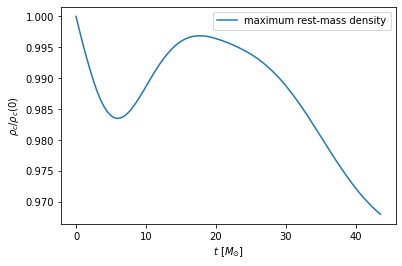

In [13]:
plt.plot(lin_data[:,1],lin_data[:,2]/lin_data[0,2], label="maximum rest-mass density")
plt.xlabel(r'$t$ [$M_{\odot}$]');
plt.ylabel(r'$\rho_c / \rho_c(0)$');
plt.legend();

### 2D Plots with Kuibit

We now do a simple 2D plot of the rest-mass density using kuibit

In [26]:
# Simulations may be composed of more runs.
# Each run is saved in a output-???? directory.
# Kuibit is able to merge all of them together so we pass to kuibit the simulation directory.
out_dir_kb=out_dir[:-12]
print(out_dir_kb)

/home/bgiacoma/simulations/TOV_ET_Dublin


In [27]:
gf = SimDir(out_dir_kb).gf

print(gf)


Available grid data of dimension 1D (x): 
[]


Available grid data of dimension 1D (y): 
[]


Available grid data of dimension 1D (z): 
[]


Available grid data of dimension 2D (xy): 
['M1', 'M3', 'gxy', 'gyz', 'vel[2]', 'eps', 'vel[0]', 'betay', 'H', 'gxz', 'gyy', 'betaz', 'w_lorentz', 'M2', 'gzz', 'rho', 'betax', 'gxx', 'alp', 'vel[1]']


Available grid data of dimension 2D (xz): 
['gxz', 'gxy', 'betax', 'eps', 'vel[2]', 'w_lorentz', 'betaz', 'rho', 'alp', 'M3', 'vel[0]', 'vel[1]', 'gzz', 'gxx', 'H', 'betay', 'M1', 'M2', 'gyy', 'gyz']


Available grid data of dimension 2D (yz): 
['gxy', 'gyy', 'vel[0]', 'vel[2]', 'eps', 'M1', 'rho', 'betax', 'gyz', 'H', 'vel[1]', 'w_lorentz', 'alp', 'gxx', 'betaz', 'M3', 'gxz', 'gzz', 'M2', 'betay']


Available grid data of dimension 3D (xyz): 
[]



In [16]:
vars2D = gf.xy
vars3D = gf.xyz

print(vars2D)
print(vars3D)


Available grid data of dimension 2D (xy): 
['M1', 'M3', 'gxy', 'gyz', 'vel[2]', 'eps', 'vel[0]', 'betay', 'H', 'gxz', 'gyy', 'betaz', 'w_lorentz', 'M2', 'gzz', 'rho', 'betax', 'gxx', 'alp', 'vel[1]']


Available grid data of dimension 3D (xyz): 
[]



In [17]:
rho = vars2D.fields.rho

In [18]:
print(rho.iterations)

[0, 2048, 4096, 6144, 8192, 10240, 12288, 14336, 16384, 18432, 20480, 22528, 24576, 26624, 28672, 30720, 32768, 34816, 36864, 38912, 40960, 43008, 45056, 47104, 49152]


In [19]:
print(rho.available_times)

[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 38.0, 40.0, 42.0, 44.0, 46.0, 48.0]


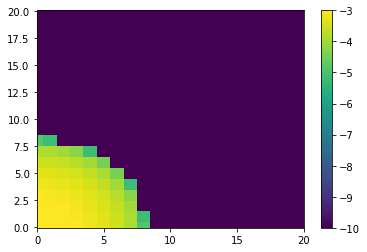

In [20]:
small_grid = UniformGrid([200, 200], x0=[0, 0], x1=[20,20])

rho_small = rho.read_on_grid(0, small_grid)

#cf = plt.contourf(*rho_small.coordinates_meshgrid(), np.log10(rho_small.data_xyz), vmin=-10, vmax=-3)
cf = plt.pcolormesh(*rho_small.coordinates_meshgrid(), np.log10(rho_small.data_xyz), vmin=-10, vmax=-3)
plt.colorbar(cf)

The following cells may take some time and they can be used to produce an animation.

In [21]:
#for i in rho.iterations:
#    print(i)
#    rho_small = rho.read_on_grid(i, small_grid)
#    cf2=plt.contourf(*rho_small.coordinates_meshgrid(), np.log10(rho_small.data_xyz), vmin=-10, vmax=-3)
#    plt.savefig("frame_"+str(i)+".png")

In [22]:
from IPython.display import HTML
import matplotlib.animation as animation
ims = []
fig,ax = plt.subplots()

for i in rho.iterations[0::1]:
    rho_small = rho.read_on_grid(i, small_grid)
    ax.set_xlabel(r'$x (M_\odot)$')
    ax.set_ylabel(r'$y (M_\odot)$')
    ax.set_aspect('equal')
    im = ax.pcolormesh(*rho_small.coordinates_meshgrid(), np.log10(rho_small.data_xyz), animated=True, vmin=-10, vmax=-3)
    plt.plot()
    plt.colorbar(im)
    title = ax.text(0.5,1.05,('Time='+str(rho.available_times[i//2048])), size=plt.rcParams["axes.titlesize"], ha="center", transform=ax.transAxes)
    ims.append([im, title])
    plt.close()
    

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
HTML(ani.to_jshtml())

<ipython-input-22-63cb689bbd8d>:13: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im)
